In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Define dataset path and image size
dataset_path = "data"  # Path to your dataset
image_size = (120, 160)  # Resize to 120x160 for Small-VGG

print('Our dataset = ')
print(os.listdir(dataset_path))



Our dataset = 
['Grupo_0', 'Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4', 'Grupo_5']


In [2]:
# Function to load images from the LG folder (following the exact structure)
def load_images_from_folder(folder_path):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    # Traverse through the group -> subject -> LG -> session -> anotherfolder -> images
    for group_folder in os.listdir(folder_path):
        group_path = os.path.join(folder_path, group_folder)
        if os.path.isdir(group_path):  # If it is a group folder
            for subject_folder in os.listdir(group_path):
                subject_path = os.path.join(group_path, subject_folder)
                if os.path.isdir(subject_path):  # If it is a subject folder
                    lg_folder = os.path.join(subject_path, "LG")  # Looking specifically for the 'LG' folder
                    if os.path.isdir(lg_folder):  # Only process if 'LG' folder exists
                        # Iterate over sessions inside 'LG' folder
                        for session_folder in os.listdir(lg_folder):
                            session_path = os.path.join(lg_folder, session_folder)
                            if os.path.isdir(session_path):  # Check each session
                                # Iterate over each subfolder inside the session
                                for subfolder in os.listdir(session_path):
                                    subfolder_path = os.path.join(session_path, subfolder)
                                    if os.path.isdir(subfolder_path):  # If it's a subfolder containing images
                                        # Now we go through all the image files
                                        for file in os.listdir(subfolder_path):
                                            if any(file.lower().endswith(ext) for ext in image_extensions):
                                                img_path = os.path.join(subfolder_path, file)
                                                try:
                                                    # Read image in grayscale and resize
                                                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                                                    if img is not None:
                                                        img = cv2.resize(img, image_size)
                                                        images.append(img)
                                                        labels.append(file[6] != '0')  # Assuming the label is based on the file name (0 or 1)
                                                        names.append(file)
                                                except Exception as e:
                                                    corruptedFiles.append((img_path, str(e)))

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    
    # Return the images, labels, and names if any images were found
    if images:
        return np.array(images), np.array(labels), np.array(names)
    else:
        print("No images were loaded.")
        return np.array([]), np.array([]), np.array([])  # Return empty arrays if no images are found

# Load dataset (only from the LG folder)
images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the LG folder with shape {images.shape}")



Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the LG folder with shape (2820, 160, 120)


In [3]:
# Perform data augmentation
def create_data_augmentation_generator(images, labels):
    # Create an ImageDataGenerator object for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,  # Rotation range of 10 degrees
        width_shift_range=0.2,  # Width shift range of 20%
        height_shift_range=0.2,  # Height shift range of 20%
        zoom_range=0.15,  # Zoom range of 15%
        fill_mode='nearest',  # Fill mode 'nearest' to avoid creating new pixels
    )
    
    # Reshaping images to 4D array (num_samples, height, width, channels)
    images_aug = images.reshape((images.shape[0], images.shape[1], images.shape[2], 1))
    
    # Return the generator that will perform the augmentation
    return datagen.flow(images_aug, labels, batch_size=16)

# Convert labels to categorical (one-hot encoding)
labels = to_categorical(labels, num_classes=2)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)



In [4]:
# Define the Small-VGG model
def create_small_vgg():
    model = Sequential()
    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    # Block 2
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    # Block 3
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    # Dense layers
    model.add(Flatten())
    model.add(Dense(7200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # Output layer for binary classification
    return model

# Compile and train the Small-VGG model
model = create_small_vgg()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data augmentation generator
train_generator = create_data_augmentation_generator(X_train, y_train)

# Train the model using the augmented data
history = model.fit(train_generator, epochs=100, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))



c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 649ms/step - accuracy: 0.7072 - loss: 67.2231 - val_accuracy: 0.7961 - val_loss: 0.5325
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 92s 652ms/step - accuracy: 0.7816 - loss: 0.5402 - val_accuracy: 0.7961 - val_loss: 0.5151
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 91s 646ms/step - accuracy: 0.7928 - loss: 0.5284 - val_accuracy: 0.7961 - val_loss: 0.5157
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 93s 655ms/step - accuracy: 0.8013 - loss: 0.5081 - val_accuracy: 0.7943 - val_loss: 0.5173
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 92s 649ms/step - accuracy: 0.8096 - loss: 0.4911 - val_accuracy: 0.7961 - val_loss: 0.5164
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 91s 645ms/step - accuracy: 0.8112 - loss: 0.4947 - val_accuracy: 0.7961 - val_loss: 0.5157
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 92s 651ms/step - accuracy: 0.7886 - loss: 0.5222 - val_accuracy: 0.7961 - val_loss: 0.5127
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 91s 646ms/step - accuracy: 0.8013 - loss: 0.50

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.80      1.00      0.89       449

    accuracy                           0.80       564
   macro avg       0.40      0.50      0.44       564
weighted avg       0.63      0.80      0.71       564



c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

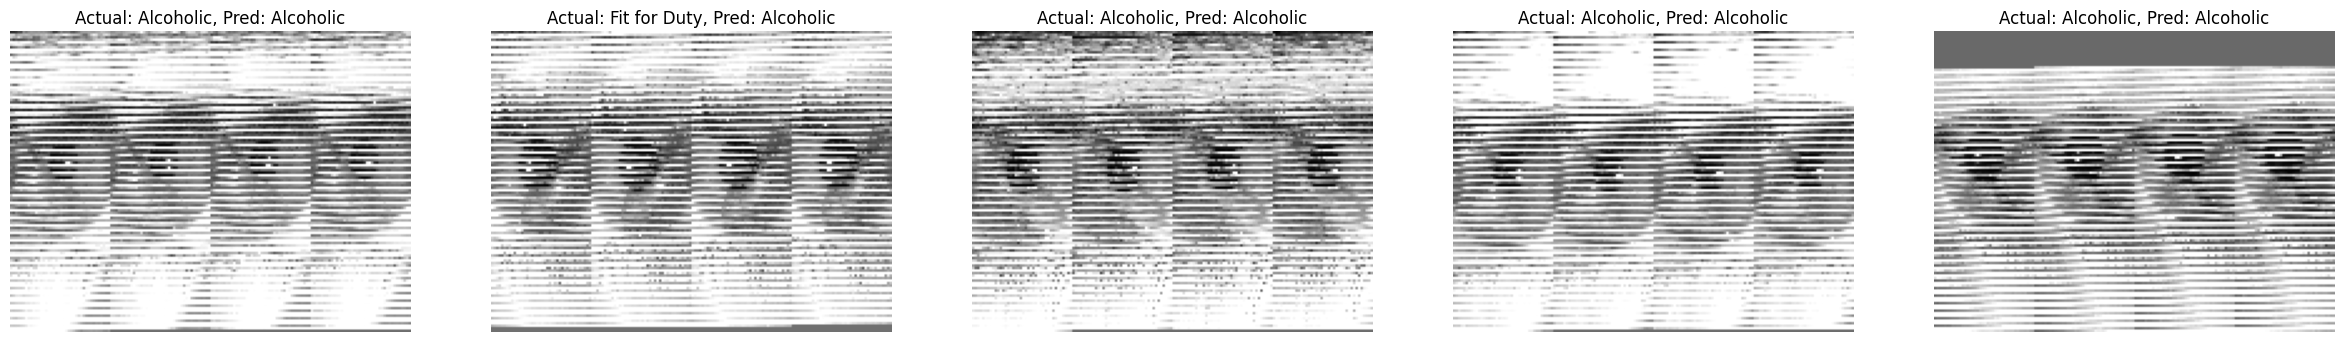

In [5]:
# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

# Visualize some test images with predictions
def plot_images(images, labels, preds, num_images=5):
    plt.figure(figsize=(30, 30))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].reshape(image_size), cmap='gray')
        actual_label = "Alcoholic" if labels[i] else "Fit for Duty"
        predicted_label = "Alcoholic" if preds[i] else "Fit for Duty"
        plt.title(f"Actual: {actual_label}, Pred: {predicted_label}")
        plt.axis('off')
    plt.show()

# Visualize predictions
plot_images(X_test, y_test_classes, y_pred_classes)
